In [1]:
# -*- coding: utf-8 -*-
"""
@author: liuxiang
persistent hypergraph homology
"""



class Hypergraph():
     
    @classmethod
    #retorna la cara d'un símplex eliminant-ne la posició índex
    def get_face(cls,path,index):
        res = []
        for i in range(len(path)):
            if i!=index:
                res.append(path[i])
        return res
    
    @classmethod
    #si el vector és buit aleshores retorna -1 i sinó doncs el màxim element
    def get_max(cls,vector):
        if len(vector)==0:
            return -1
        else:
            return max(vector)
        
    @classmethod
    #fa la suma simètrica XOR del conjunt a amb el conjunt b i retorna el resultat
    def add_two_column(cls,a,b):
        for item in a: 
            if item in b:
                b.remove(item)
            else:
                b.add(item)
        return b
    
    @classmethod
    #retorna una copia de v
    def get_copy_vector(cls,v):
        res = []
        for i in v:
            res.append(i)
        return set(res)
    
    @classmethod
    #resol una equació lineal, intenta reduir el vector a zero sumant columnes B 
    def solve_equation(cls,vector,B,L):
        # Si el vector és zero, no cal reduir
        if len(vector)==0:
            return [1,[]]
        solution = []
        N = Hypergraph.get_max(vector)  # pivot: major índex amb 1
        # Mentre hi hagi pivot i hi hagi columna per eliminar-lo
        while N!=-1 and L[N]!=-1:
            vector = Hypergraph.add_two_column(B[L[N]],vector) # suma mòdul 2
            solution.append(L[N]) # guardem la columna usada
            N = Hypergraph.get_max(vector)  # nou pivot
        # Retornem segons si hem reduït del tot o no
        if N==-1:
            return [1,solution]
        elif L[N]==-1:
            return [0,vector]
        
    @classmethod
    #combina dues col·leccions de vector en una única matriu 
    #D-L és la taula de pivots de D
    def combine_D_M(cls,D,D_L,M,length,MM):
        #nova base combinada D+M reduïda
        DM = []
        D_end = len(D)
        DM_L = []
        add_index = []
        #copiem D dins de DM
        for item in D:
            temp1 = []
            for i in item:
                temp1.append(i)
            DM.append(set(temp1))
        #inicialitza DM_L i copia D_L 
        for i in range(length):
            DM_L.append(-1)
        for i in range(len(D_L)):
            DM_L[i] = D_L[i]
        
        c = 0
        zero_number = 0
        #inenta reduir M amb les columnes de DM
        for j in range(len(M)):
            N = Hypergraph.get_max(M[j])
            while N!=-1 and DM_L[N]!=-1:
                M[j] = Hypergraph.add_two_column(DM[ DM_L[N] ], M[j])
                if DM_L[N]>=D_end:
                    MM[j] = Hypergraph.add_two_column(MM[ DM_L[N]-D_end+zero_number ], MM[j])
                N = Hypergraph.get_max(M[j])

            #vector reduït completament, aleshore no s'afegeix a DM
            if N==-1:
                zero_number = zero_number + 1
                continue
            #si el vector no es pot reduir aleshores s'afegeix a la base
            elif DM_L[N]==-1:
                DM_L[N] = c + D_end
                c = c + 1
                DM.append(M[j])
                add_index.append(j)
        #retorna la nova base de DM i els seus pivots DM_L
        return [ [DM,DM_L],D_end,add_index ]
    
    @classmethod
    #compta quants elements de ls son menors que a
    def get_smaller_number(cls,a,ls):
        res = 0
        for i in ls:
            if i<a:
                res = res + 1
        return res
    
    #Inicialitza el hipergraf i prepara totes les estructures per calcular l’homologia persistent.
    def __init__(self,hyperedge):
        #self.Vertex = vertex # vertex
        #self.Vertex_Number = len(vertex)
        self.WH = hyperedge
        self.WH.sort(key=lambda x:(x[1], len(x[0])))
        self.H = []
        self.KH = []
        self.W = []
        self.H_Number = 0
        self.KH_Number = 0
        self.set_KH()
        self.Sup_Basis = []
        self.Inf_Basis = []
        self.Sup_Matrix = []
        self.Inf_Matrix = []
        self.Sup_Weight = []
        self.Inf_Weight = []
        self.Sup_Dimension = []
        self.Inf_Dimension = []
        self.Sup_L = []
        self.Inf_L = []
        self.Inf_Index = []
        self.Diagram = {}
        
    #construeix la clausura simplicial a partir de les hiperarestes   
    def set_KH(self):
        for item in self.WH:
            self.H.append(item[0]) #llista de les hiperarestes
            self.W.append(item[1]) 
            self.KH.append(item[0]) #llista dels simplexos
        #crea la clausura simplicial
        for item in self.H:
            for i in range(len(item)):
                face = Hypergraph.get_face(item,i)
                if face not in self.H:
                    if len(face)>0:
                        self.KH.append(face)
        self.H_Number = len(self.H)
        self.KH_Number = len(self.KH)
    
    #retorna el conjunt d'índexs dins de self.KH. Aquests índexs s'usen per construir la matriu frontera. 
    def get_boundary(self,temp):
        if len(temp)==1:
            return set()
        res = set()
        for i in range(len(temp)):
            face = Hypergraph.get_face(temp,i)
            index = self.KH.index(face)
            res.add(index)
        return res
    
    #Construeix el complex de cadenes suprem:
    def supremum_chain_complex(self):
        #s'inicialitza la taula de pivots (-1 vol dir q no té pivot assignat)
        for i in range(self.KH_Number):
            self.Sup_L.append(-1)
        #Es recorre cada hiperaresta de H
        for j in range(self.H_Number):
            #vector amb el simplex corresponent a la hiperaresta actual
            vector_now = set([self.KH.index(self.H[j])])
            #Es mira si es pot generar amb la base
            solution1 = Hypergraph.solve_equation(vector_now,self.Sup_Basis,self.Sup_L)
            if solution1[0]==1:
                continue #no cal afegir-lo pq ja està generat
            else:
                #si no és independent, és mira si la seva vora sí que ho es 
                temp_boundary = self.get_boundary(self.H[j])
                solution2 = Hypergraph.solve_equation(temp_boundary,self.Sup_Basis,self.Sup_L)
                #si la frontera es dependent però el símplex no, s'afegeix el vector com a nova base
                if solution2[0]==1:
                    self.Sup_Basis.append(solution1[1])
                    temp_N = len(self.Sup_Basis)
                    self.Sup_L[max(solution1[1])] = temp_N - 1
                    self.Sup_Matrix.append(set(solution2[1]))
                    self.Sup_Weight.append(self.W[j])
                    self.Sup_Dimension.append(len(self.H[j])-1)
                #si cap dels dos és dependent, aleshores s'afegeixen els dos a la base
                else:
                    self.Sup_Basis.append(solution2[1])
                    temp_N = len(self.Sup_Basis)
                    self.Sup_L[max(solution2[1])] = temp_N -1
                    self.Sup_Basis.append(solution1[1])
                    self.Sup_L[max(solution1[1])] = temp_N
                    self.Sup_Matrix.append(set())
                    temp_N = len(self.Sup_Matrix)
                    self.Sup_Matrix.append(set([temp_N-1]))
                    self.Sup_Weight.append(self.W[j])
                    self.Sup_Weight.append(self.W[j])
                    self.Sup_Dimension.append(len(self.H[j])-2)
                    self.Sup_Dimension.append(len(self.H[j])-1)
        
    #Per determinar quins símplexs formen part del complex ínfim, és a dir, aquells que es poden generar a partir de les seves vores o d'altres símplexs.    
    def set_infimum_index(self):
        D = []  #base actual de símplexs
        partial_D = [] #vores
        D_L = []
        for i in range(self.KH_Number):
            D_L.append(-1)
        for j in range(self.H_Number):
            sigma_now = self.H[j]
            vector_now = set([self.KH.index(sigma_now)])  #símplex actual com a vector
            temp_boundary = self.get_boundary(sigma_now)  #la seva vora
            
            now_D = []
            now_partial_D = []
            now_D_L = []
            for item in D:
                now_D.append(Hypergraph.get_copy_vector(item))
            for item in partial_D:
                now_partial_D.append(Hypergraph.get_copy_vector(item))
            for item in D_L:
                now_D_L.append(item)

            #combina base i fronteres
            [DM,D_end,partial_D_index] = Hypergraph.combine_D_M(now_D,now_D_L,now_partial_D,self.KH_Number,now_D)
            temp_boundary2 = Hypergraph.get_copy_vector(temp_boundary)
            # prova si la vora de símplex és pot generar amb la base
            solution1 = Hypergraph.solve_equation(temp_boundary2,DM[0],DM[1])
            if solution1[0]==1:
                self.Inf_Index.append(j)
            # prova si el símplex sencer també és generable
            sigma = Hypergraph.get_copy_vector(vector_now)
            solution2 = Hypergraph.solve_equation(sigma, DM[0], DM[1])
            if solution2[0]==1:
                temp_M = partial_D_index[max(solution2[1])-D_end]
                self.Inf_Index.append(temp_M)
            #actualitza la base amb el nou símplex i la seva vora
            D.append(vector_now)
            temp_N = len(D)
            D_L[max(vector_now)] = temp_N - 1 
            partial_D.append(temp_boundary)

    #Construeix el complex de cadenes infim a partir del complex suprem
    def infimum_chain_complex(self):
        self.supremum_chain_complex()
        self.set_infimum_index()      
        candidate = []
        #Es seleccionen els vectors de la base del suprem que tenen com a pivot un índex de l'ínfim
        for i in range(len(self.Sup_Basis)):
            temp = max(self.Sup_Basis[i]) #el pivot del vector
            if temp in self.Inf_Index:
                candidate.append(i)
        #ara s'anoten els que no son candidats al infim 
        inf_candidate = []
        for i in range(len(self.Sup_Basis)):
            if i not in candidate:
                inf_candidate.append(i)
        #es construeix la matriu vora de l'ínfim usant els candidats
        for i in range(len(self.Sup_Matrix)):
            if i in candidate:
                temp1 = self.Sup_Matrix[i]
                temp2 = set()
                for item in temp1:
                    if item in candidate:
                        temp2.add(item)
                temp3 = set()
                for item in temp2:
                    temp4 = Hypergraph.get_smaller_number(item,inf_candidate)
                    temp5 = item - temp4
                    temp3.add(temp5)
                self.Inf_Matrix.append(temp3)
                self.Inf_Weight.append(self.Sup_Weight[i])
                self.Inf_Dimension.append(self.Sup_Dimension[i])
           
        
    def persistence_from_supremum(self,Dim):
        self.supremum_chain_complex() #calcula el complex
        inf_bar = []
        finite_bar = []  #parelles (birth, death)
        t = len(self.Sup_Matrix)
        L = [] #pivots
        for i in range(t):
            L.append(-1)

        #reducció de la matriu Sup_Matrix per columnes
        for j in range(t):
            N = Hypergraph.get_max(self.Sup_Matrix[j])
            while N!=-1 and L[N]!=-1:
                self.Sup_Matrix[j] = Hypergraph.add_two_column(self.Sup_Matrix[L[N]],self.Sup_Matrix[j])
                N = Hypergraph.get_max(self.Sup_Matrix[j])
            if N==-1:
                inf_bar.append(j)
            elif L[N]==-1:
                L[N] = j
        #genera les barres finites
        for j in range(t):
            low_j = Hypergraph.get_max(self.Sup_Matrix[j])
            if low_j!=-1:
                inf_bar.remove(low_j)
                finite_bar.append([low_j,j])
        
        #inicialitza el diagrama per a cada dimensió 
        for i in range(Dim):
            self.Diagram[str(i)] = []
        #s'afegeixen les barres infinites
        for i in inf_bar: 
            self.Diagram[str(self.Sup_Dimension[i])].append([self.Sup_Weight[i],-1])
        #s'afegeixen les barres finites
        for item in finite_bar:
            if self.Sup_Weight[item[1]]>self.Sup_Weight[item[0]]:
                self.Diagram[str(self.Sup_Dimension[item[0]])].append([ self.Sup_Weight[item[0]],self.Sup_Weight[item[1]] ])
        return self.Diagram
    
    # Aplica reducció mòdul 2 al complex infimum per calcular el diagrama de persistència.
    def persistence_from_infimum(self,Dim):
        self.infimum_chain_complex()
        inf_bar = []
        finite_bar = []
        t = len(self.Inf_Matrix)
        L = []
        for i in range(t):
            L.append(-1)
        for j in range(t):
            N = Hypergraph.get_max(self.Inf_Matrix[j])
            while N!=-1 and L[N]!=-1:
                self.Inf_Matrix[j] = Hypergraph.add_two_column(self.Inf_Matrix[L[N]],self.Inf_Matrix[j])
                N = Hypergraph.get_max(self.Inf_Matrix[j])
            if N==-1:
                inf_bar.append(j)
            elif L[N]==-1:
                L[N] = j
        
        for j in range(t):
            low_j = Hypergraph.get_max(self.Inf_Matrix[j])
            if low_j!=-1:
                inf_bar.remove(low_j)
                finite_bar.append([low_j,j])
        
        for i in range(Dim):
            self.Diagram[str(i)] = []
        for i in inf_bar: 
            self.Diagram[str(self.Inf_Dimension[i])].append([self.Inf_Weight[i],-1])
        for item in finite_bar:
            if self.Inf_Weight[item[1]]>self.Inf_Weight[item[0]]:
                self.Diagram[str(self.Inf_Dimension[item[0]])].append([ self.Inf_Weight[item[0]],self.Inf_Weight[item[1]] ])
        return self.Diagram
    

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from persim import plot_diagrams
#xmax es el valor màxim de l'eix x
def plot_barcode_and_diagram(bar_inf, xmax=2025):

    #llista buida per guardar els diagrames per dimensió
    dgms = []
    #maxima dimensió present a les dades
    max_dim = max(int(k) for k in bar_inf.keys())

    #per cada dimensió
    for dim in range(max_dim + 1):
        #recupera les parelles [naixement, mort]
        raw = bar_inf.get(str(dim), [])
        #si existeix la parella ho convertim en un numpy array, sino crea un de buit
        if raw:
            dgm = np.array(raw, dtype=float)
        else:
            dgm = np.empty((0, 2))
        #canviem els valors -1 per np.inf
        dgm[dgm == -1] = np.inf
        #afesim el diagrama a la llista
        dgms.append(dgm)

    #figura amb dues subgràfiques, una fila i dues columnes. La primera serà el diagrama de persistència i la segona el codi de barres
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # dibuix del diagrama de persistència, cada parella [naixement,mort] és un punt
    plot_diagrams(dgms, ax=axs[0], title="Diagrama de persistència")

    # 📍 Part 2: Codi de barres estilitzat
    y = 0
    #gruix de les barres
    bar_height = 0.5
    colors = ['blue', 'orange', 'green', 'red', 'purple', '#ffff33']
# H0, H1, H2, ..., H5 colors

    #recorre cada diagrama. Cada diagrama és una matriu de parelles [naixement,nort]
    for dim, diagram in enumerate(dgms):
        #recorre cada parella 
        for birth, death in diagram:
            #si la mort és infinita, és substitueix per un valor màxim per poder-ho dibuixar
            if np.isinf(death):
                death = xmax
            #dibuixem una barra horitzontal des del "naixement" fins a "mort". La barra es situa a l'alçada y
            axs[1].add_patch(plt.Rectangle((birth, y), death - birth, bar_height,
                                           color=colors[dim % len(colors)], alpha=0.7))
            #cada barra nova és puja una mica més amunt pq no es sobreposin
            y += 1

    #definim l'eix x
    axs[1].set_xlim(left=min([birth for d in dgms for birth, _ in d] + [2010]) - 1, right=xmax + 1)
    axs[1].set_ylim(0, y + 5)
    axs[1].set_xlabel("Filtració (anys)")
    #eliminem etiquetes de l'eix y
    axs[1].set_yticks([])
    axs[1].set_title("Codi de barres")
    #axs[1].grid(True, axis='x')

    # Llegenda
    labels = [f"H{dim}" for dim in range(len(dgms)) if len(dgms[dim]) > 0]
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors[dim % len(colors)], alpha=0.7) for dim in range(len(labels))]
    axs[1].legend(handles, labels, loc="lower right")

    plt.tight_layout()
    plt.show()


In [4]:
import math
def entropia_per_dimensio(barcode: dict):
    #aquí guardarem l'entropia per dimensió
    resultats = {}
    # Recorrem cada dimensió i les seves barres
    for dim, bars in barcode.items():
        longituds = []
        for birth, death in bars:
            if death != -1: #ignorem barres infinites
                l = death - birth
                if l > 0:
                    longituds.append(l) # Guardem longituds positives
        if longituds:
            L = sum(longituds) #longitud total (per calcular les probabilitats que formen part de l'entropia)
            entropia = -sum((l/L) * math.log2(l/L) for l in longituds)
        else:
            entropia = 0.0
        resultats[dim] = entropia
        print(f"Entropia dim {dim}: {entropia:.4f}")
    return resultats


In [7]:
#Es fa el mateix que abans però amb barres infinites. Per aquestes s'agafa que la seva mort es l'últim any de la filtració
def entropia_infinites_per_dimensio(barcode: dict, maxim_filtracio=2024):
    resultats = {}
    for dim, bars in barcode.items():
        longituds = []
        for birth, death in bars:
            if death == -1:
                l = maxim_filtracio - birth
                if l > 0:
                    longituds.append(l)
        if longituds:
            L = sum(longituds)
            entropia = -sum((l / L) * math.log2(l / L) for l in longituds)
        else:
            entropia = 0.0
        resultats[dim] = entropia
        print(f"Entropia infinites dim {dim}: {entropia:.4f}")
    return resultats

In [9]:
def calcular_persistencies(barcode, maxim_filtracio=2024):
    descriptors = {}

    for dimensio, barres in barcode.items():
        #per calcular la persistència total de les barres finites i infinites. També el número total de barres tant finites com infinites
        persistencia_finites = 0
        persistencia_infinites = 0
        num_finites = 0
        num_infinites = 0

        #si es finita aleshores contribueix a les finies
        for birth, death in barres:
            if death != -1:
                persistencia_finites += (death - birth)
                num_finites += 1
            #si son infinites aleshores contribueixen a la suma total de les infinites
            else:
                persistencia_infinites += (maxim_filtracio - birth)
                num_infinites += 1

        descriptors[int(dimensio)] = {
            'persistencia_total_finites': persistencia_finites,
            'persistencia_total_infinites': persistencia_infinites,
            'num_total_finites': num_finites,
            'num_total_infinites': num_infinites
        }

        # 🖨️ Mostrar resultats en format columna
        print(f"Dimensió {dimensio}:")
        print(f"  Persistència total finites:    {persistencia_finites}")
        print(f"  Persistència total infinites:  {persistencia_infinites}")
        print(f"  Nombre total de barres finites:  {num_finites}")
        print(f"  Nombre total de barres infinites: {num_infinites}")
        print()  # línia buida per llegibilitat

    return descriptors


In [11]:
from itertools import chain, combinations #chain concatena diversos iterables en una sola seqüència i combinations genera tots els subconjunts 

def generar_simplices(hipergraf_llista):
    simplices = {}
    for hiperaresta, t in hipergraf_llista:
        # Generar tots els subconjunts no buits
        nodes = hiperaresta  #conté els vèrtexs de la hiperaresta actual
        for k in range(1, len(nodes) + 1):
            for subset in combinations(nodes, k):
                subset = list(subset)
                # Assignar el mínim t (valor de la filtració, en el nostre cas any) possible a cada simplex
                if tuple(subset) not in simplices or t < simplices[tuple(subset)]:
                    simplices[tuple(subset)] = t
    # Ordenar per t i convertir a llista
    KH = []
    for simplex, t in simplices.items():
        KH.append([list(simplex), t])
    # Ordenar per t i per dimensió (opcional)
    KH.sort(key=lambda x: (x[1], len(x[0])))
    return KH 

In [13]:
import feedparser        # analitza XML de l’API d’arXiv
import requests          # fa peticions HTTP

def obtenir_hipergraf_llista(area="math.ST", any_inici=2004, any_fi=2024,
                           max_per_any=200):
    #torna una llista de parells [autors, any] sense duplicats i ordenada per any de manera creixent
    edges_global = {}        # clau = tuple(autors), valor = any

    for any_ in range(any_inici, any_fi + 1):
        data_inici = f"{any_}01010000"
        data_fi    = f"{any_}12312359"
        query = (f"cat:{area}+AND+submittedDate:[{data_inici}+TO+{data_fi}]")
        url   = ("http://export.arxiv.org/api/query?"
                 f"search_query={query}&start=0&max_results={max_per_any}")

        #descarrega i desa el arxiu XML
        xml = requests.get(url).text
        #with open(f"arxiv_{area}_{any_}.xml", "w", encoding="utf-8") as f:
            #f.write(xml)
        feed = feedparser.parse(xml)
        
        #iteració per cada article
        for entry in feed.entries:
            #extreiem la llista d'autors de l'article
            autors = [a.name.strip() for a in entry.authors]
            if not autors:
                continue
            #set elimina autors repetits dins l'article, sorted els ordena alfabèticament i tuple ho converteix a tuple
            autors_ordenats = tuple(sorted(set(autors)))   
            #serveix pq si una hiperaresta surt diversos anys,només guardem l'any més antic
            #si es la primera vegada q veiem la hiperaresta o no es la primera vegada pero s'ha vist en un any més antic
            if autors_ordenats not in edges_global or any_ < edges_global[autors_ordenats]:
                edges_global[autors_ordenats] = any_

    #construim la llista de [autors, any_minim]
    hipergraf_llista = [[list(k), t] for k, t in edges_global.items()]
    #ordenem per any creixent i pel nombre d'autors tmb creixent
    #hipergraf_llista.sort(key=lambda x: (x[1], len(x[0])))
    #nomes ordenem per any creixent
    hipergraf_llista.sort(key=lambda x: x[1])

    return hipergraf_llista
    
hipergraf_llista = obtenir_hipergraf_llista()
#imprimir les 5 primeres hiperarestes amb ek seu any
for grup, any_min in hipergraf_llista[:5]:
    print(f"{any_min}: {grup}")

#print(hipergraf_llista)

2004: ['H. Dennis Tolley', 'Igor Akushevich', 'Kenneth G. Manton', 'Mikhail Kovtun']
2004: ['Geurt Jongbloed', 'Jon A. Wellner', 'Piet Groeneboom']
2004: ['Eric D. Kolaczyk', 'Robert D. Nowak']
2004: ['Yannick Baraud']
2004: ['Mark G. Low', 'T. Tony Cai']


In [14]:
#Calculem el codi de barres de l'homologia persistent de l'hipergraf usant el complex suprem 
a = Hypergraph(hipergraf_llista)
dim = 3 
bar_sup = a.persistence_from_supremum(dim)  

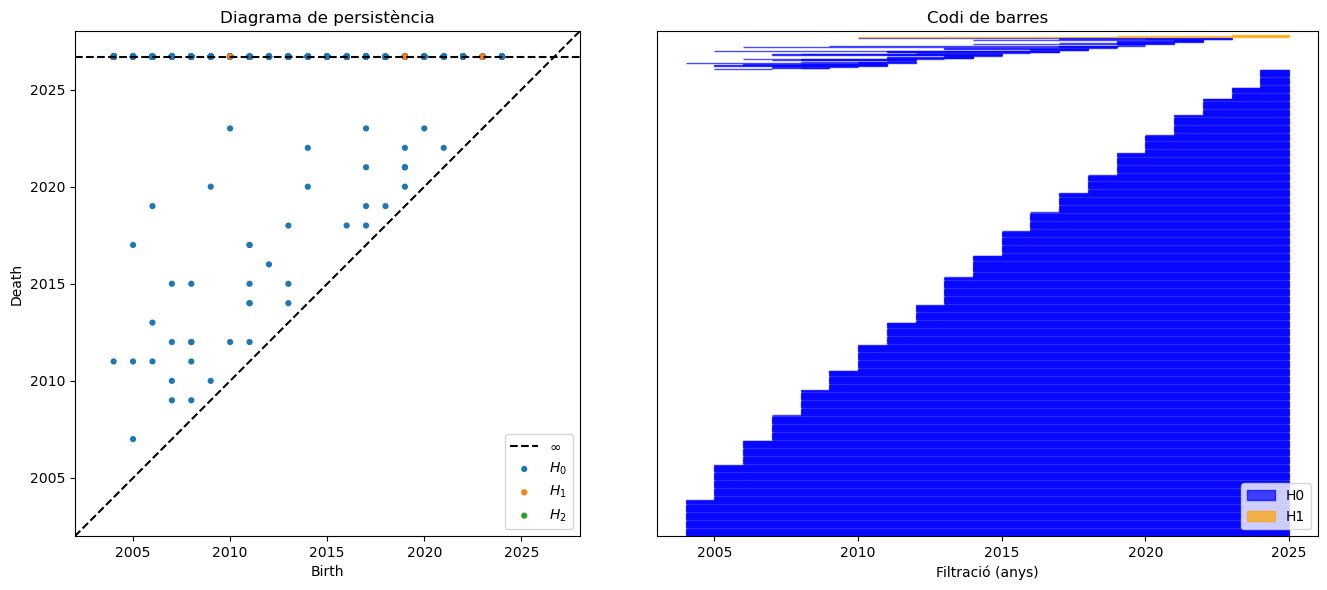

In [15]:
#Imprimim el diagrama de persistència i el codi de barres dels resultats obtinguts anteriorment
plot_barcode_and_diagram(bar_sup)

In [16]:
#calculem les persistències totals, número de barres totals  i entropia per a cada dimensió i tant per barres finites com infinites
resultatsdescriptors=calcular_persistencies(bar_sup, maxim_filtracio=2024)
entropia_persistent_sup=entropia_per_dimensio(bar_sup)
entropiaInfinita=entropia_infinites_per_dimensio(bar_sup, maxim_filtracio=2024)


Dimensió 0:
  Persistència total finites:    193
  Persistència total infinites:  7206
  Nombre total de barres finites:  44
  Nombre total de barres infinites: 642

Dimensió 1:
  Persistència total finites:    0
  Persistència total infinites:  20
  Nombre total de barres finites:  0
  Nombre total de barres infinites: 3

Dimensió 2:
  Persistència total finites:    0
  Persistència total infinites:  0
  Nombre total de barres finites:  0
  Nombre total de barres infinites: 0

Entropia dim 0: 5.0995
Entropia dim 1: 0.0000
Entropia dim 2: 0.0000
Entropia infinites dim 0: 9.0694
Entropia infinites dim 1: 1.0763
Entropia infinites dim 2: 0.0000


In [17]:
#Generem una filtració a on cada pas de la filtració apareix la clausura simplicial de cada hipergraf de la filtració posterior
KH = generar_simplices(hipergraf_llista)
print(KH[:10]) 
#print(KH)

[[['Yannick Baraud'], 2004], [['Ching-Kang Ing'], 2004], [['Jae Kwang Kim'], 2004], [['Hemant Ishwaran'], 2004], [['Florentina Bunea'], 2004], [['Keith Knight'], 2004], [['Robert A. Stine'], 2004], [['Berwin A. Turlach'], 2004], [['Sanford Weisberg'], 2004], [['R. Dennis Cook'], 2004]]


In [22]:
#calculem ara la homologia persistent de la filtració amb les clausures simplicials 
b = Hypergraph(KH)
dim = 3
bar_sup_KH = b.persistence_from_supremum(dim)

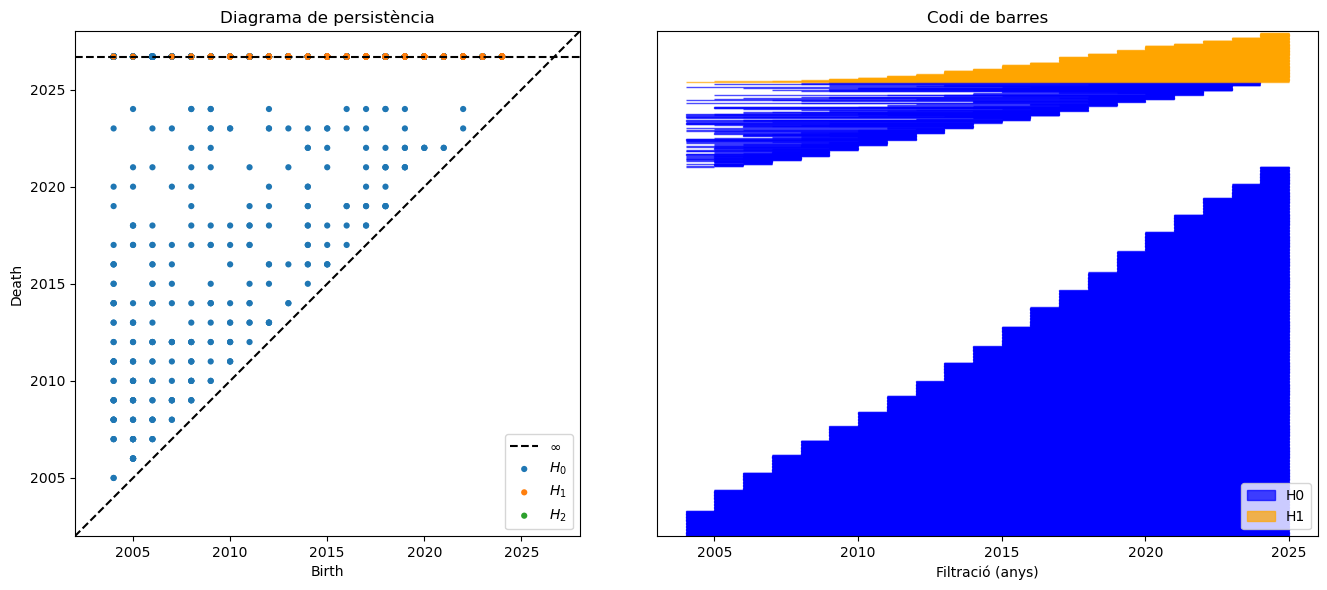

In [24]:
#imprimim el codi de barres i el diagrama de persistència dels resultats obtinguts anteriorment
plot_barcode_and_diagram(bar_sup_KH)

In [26]:
#calculem els descriptors númerics per a cada dimensió i tant per barres finites com infinites, de la filtració amb la clausura simplicial
resultatsdescriptors=calcular_persistencies(bar_sup_KH, maxim_filtracio=2024)
entropia_persistent_sup=entropia_per_dimensio(bar_sup_KH)
entropiaInfinita=entropia_infinites_per_dimensio(bar_sup_KH, maxim_filtracio=2024)

Dimensió 0:
  Persistència total finites:    1579
  Persistència total infinites:  12461
  Nombre total de barres finites:  282
  Nombre total de barres infinites: 1226

Dimensió 1:
  Persistència total finites:    0
  Persistència total infinites:  1088
  Nombre total de barres finites:  0
  Nombre total de barres infinites: 162

Dimensió 2:
  Persistència total finites:    0
  Persistència total infinites:  0
  Nombre total de barres finites:  0
  Nombre total de barres infinites: 0

Entropia dim 0: 7.7575
Entropia dim 1: 0.0000
Entropia dim 2: 0.0000
Entropia infinites dim 0: 9.9467
Entropia infinites dim 1: 6.9543
Entropia infinites dim 2: 0.0000


In [ ]:
#per alliberar memória
del bar_sup
del a
del bar_sup_KH
del b
del pers_total_sup
del entropia_persistent_sup
import gc
gc.collect()

import matplotlib.pyplot as plt
plt.close('all')